In [1]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [2]:
from numpy.random.mtrand import random
import pandas as pd
import numpy as np


#Loading the datasets

train_df =pd.read_csv("/kaggle/input/twitter-depression-dataset/df_train.csv")

test_df =pd.read_csv("/kaggle/input/twitter-depression-dataset/df_test.csv")
val_df = pd.read_csv('/kaggle/input/twitter-depression-dataset/df_val.csv')
train_df = pd.concat([train_df, val_df], axis=0)
# renaming dataset columns
train_df = train_df.rename(columns={
    "Text" : "text",
    "Sentiment" : "label"
})
test_df = test_df.rename(columns={
    "Text" : "text",
    "Sentiment" : "label"
})

val_df = val_df.rename(columns={
    "Text" : "text",
    "Sentiment" : "label"
})
#Combinimg the train and val datasets into oneset

#train_df = pd.concat([train_df, val_df], axis=0)
train_df["label"] = train_df["label"].astype(int)
test_df["label"] = test_df["label"].astype(int)
#val_df["label"] = val_df["label"].astype(int)

train_df.head(10)

,Unnamed: 0,text,label
0,0,just finished my second exam only one more to go,0
1,1,i was so much happier in prison ever since i c...,3
2,2,can depression be cured by positivity anxiety ...,3
3,3,rt ur wcw takes depression naps a day worrie...,2
4,4,reeselasher you guys are hilarious why not jus...,0
5,5,thewiselemonpie is it broken i suddenly cant g...,2
6,6,is so sickcries,2
7,7,everythings happenenig wayy too fast jesus p...,0
8,8,lsn no problem thanks for your help my widget ...,0
9,9,get free tips and tricks on almost anything at...,0


In [3]:
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datetime import datetime
import json
from tqdm import tqdm
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Labels
LABEL_MAPPING = {
    0: 'No Depression',
    1: 'Mild Depression',
    2: 'Moderate Depression',
    3: 'Severe Depression'
}

# Custom slang/contraction dictionary
slang_dict = {
    "rt": "",
    "u": "you",
    "ur": "your",
    "r": "are",
    "ppl": "people",
    "ive": "i have",
    "im": "i am",
    "idk": "i do not know",
    "dont": "do not",
    "cant": "cannot",
    "wont": "will not",
    "didnt": "did not",
    "doesnt": "does not",
    "isnt": "is not",
    "wasnt": "was not",
    "aint": "is not",
    "shes": "she is",
    "hes": "he is",
    "theyre": "they are",
    "ill": "i will",
    "youre": "you are",
    "itll": "it will",
    "id": "i would",
    "lol": "laughing"
}

def expand_slang(text):
    return ' '.join([slang_dict.get(word, word) for word in text.split()])

def clean_text(text):
    # Convert emojis to descriptive text
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = text.lower()
    
    # Remove URLs, mentions, hashtags, numbers, punctuation
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Expand slang
    text = expand_slang(text)

    # Tokenize and lemmatize
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    
    return text

def preprocess_dataset(df):
    df = df.dropna(subset=['text'])
    df['cleaned_text'] = df['text'].apply(clean_text)
    return df

# Apply preprocessing
df_tr = preprocess_dataset(train_df)
df_tes = preprocess_dataset(test_df)[['cleaned_text', 'label']]
df_tr


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Unnamed: 0,text,label,cleaned_text
0,0,just finished my second exam only one more to go,0,just finished my second exam only one more to go
1,1,i was so much happier in prison ever since i c...,3,i wa so much happier in prison ever since i ca...
2,2,can depression be cured by positivity anxiety ...,3,can depression be cured by positivity anxiety ...
3,3,rt ur wcw takes depression naps a day worrie...,2,your wcw take depression nap a day worry about...
4,4,reeselasher you guys are hilarious why not jus...,0,reeselasher you guy are hilarious why not just...
...,...,...,...,...
10390,69286,comcast is saying someone called on behalf amp...,2,comcast is saying someone called on behalf amp...
10391,69287,rt medelmarr yeah u cute but are u good for my...,0,medelmarr yeah you cute but are you good for m...
10392,69288,jimparedes haha the ror made sense since japs ...,0,jimparedes haha the ror made sense since jap h...
10393,69289,mikedillard looking to move to austin beefing ...,0,mikedillard looking to move to austin beefing ...


# 4.2 Hyper-parameter selection

- To optimize model performance, a systematic grid search was conducted over the hyperparameter space defined by variations in learning rate and batch size, while keeping the number of training epochs fixed at 3. 

In [16]:
def run_grid_search(train_df, test_df, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    learning_rates = [1e-5, 2e-5, 3e-5]
    batch_sizes = [16, 32]
    epochs_list = [3]  # 

    combinations = list(itertools.product(learning_rates, batch_sizes, epochs_list))
    best_accuracy = 0
    best_config = {}

    for lr, batch_size, num_epochs in combinations:
        print(f"\n🔍 Trying: Model={model_name}, LR={lr}, Batch={batch_size}, Epochs={num_epochs}")
        
        train_dataset = DepressionDataset(
            texts=train_df['cleaned_text'].tolist(),
            labels=train_df['label'].tolist(),
            tokenizer=tokenizer
        )
        test_dataset = DepressionDataset(
            texts=test_df['cleaned_text'].tolist(),
            labels=test_df['label'].tolist(),
            tokenizer=tokenizer
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                    num_training_steps=total_steps)

        for epoch in range(num_epochs):
            train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler)
            print(f"  Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Loss: {train_loss:.4f}")

        test_acc, test_loss = eval_model(model, test_loader)
        print(f"✅ Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_config = {
                "model": model_name,
                "learning_rate": lr,
                "batch_size": batch_size,
                "epochs": num_epochs,
                "test_accuracy": test_acc,
                "test_loss": test_loss
            }
            save_path = f"best_lr_model_{model_name.replace('/', '_')}"
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)
            print(f"✅ Best model saved at {save_path}!")

    print("\n🏆 Best Hyperparameter Configuration:")
    for k, v in best_config.items():
        print(f"{k}: {v}")

    return best_config


In [17]:
from sklearn.model_selection import train_test_split

df_sample = df_val
train_df, test_df = train_test_split(
    df_sample,
    test_size=0.2,
    stratify=df_sample['label'],
    random_state=42
)

model_names = [
    "bert-base-uncased",
    "distilbert-base-uncased",
    "roberta-base"
]

results = []
for model_name in model_names:
    print(f"\n===== Running grid search for: {model_name} =====")
    best = run_grid_search(train_df, test_df, model_name)
    results.append(best)



===== Running grid search for: bert-base-uncased =====

🔍 Trying: Model=bert-base-uncased, LR=1e-05, Batch=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6950 | Loss: 0.7257
  Epoch 2 | Train Acc: 0.8036 | Loss: 0.4950
  Epoch 3 | Train Acc: 0.8507 | Loss: 0.4026
✅ Test Accuracy: 0.7844 | Loss: 0.5283
✅ Best model saved at best_lr_model_bert-base-uncased!

🔍 Trying: Model=bert-base-uncased, LR=1e-05, Batch=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6212 | Loss: 0.8263
  Epoch 2 | Train Acc: 0.7582 | Loss: 0.5706
  Epoch 3 | Train Acc: 0.8042 | Loss: 0.4909
✅ Test Accuracy: 0.7724 | Loss: 0.5397

🔍 Trying: Model=bert-base-uncased, LR=2e-05, Batch=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.7273 | Loss: 0.6428
  Epoch 2 | Train Acc: 0.8282 | Loss: 0.4293
  Epoch 3 | Train Acc: 0.8993 | Loss: 0.2887
✅ Test Accuracy: 0.7695 | Loss: 0.5900

🔍 Trying: Model=bert-base-uncased, LR=2e-05, Batch=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6860 | Loss: 0.7120
  Epoch 2 | Train Acc: 0.8046 | Loss: 0.4741
  Epoch 3 | Train Acc: 0.8633 | Loss: 0.3573
✅ Test Accuracy: 0.7820 | Loss: 0.5326

🔍 Trying: Model=bert-base-uncased, LR=3e-05, Batch=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.7210 | Loss: 0.6416
  Epoch 2 | Train Acc: 0.8365 | Loss: 0.4086
  Epoch 3 | Train Acc: 0.9195 | Loss: 0.2310
✅ Test Accuracy: 0.7868 | Loss: 0.6031
✅ Best model saved at best_lr_model_bert-base-uncased!

🔍 Trying: Model=bert-base-uncased, LR=3e-05, Batch=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.7061 | Loss: 0.6705
  Epoch 2 | Train Acc: 0.8283 | Loss: 0.4345
  Epoch 3 | Train Acc: 0.8989 | Loss: 0.2819
✅ Test Accuracy: 0.7844 | Loss: 0.5722

🏆 Best Hyperparameter Configuration:
model: bert-base-uncased
learning_rate: 3e-05
batch_size: 16
epochs: 3
test_accuracy: 0.7868142444658325
test_loss: 0.6030993233506496

===== Running grid search for: distilbert-base-uncased =====

🔍 Trying: Model=distilbert-base-uncased, LR=1e-05, Batch=16, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6873 | Loss: 0.7260
  Epoch 2 | Train Acc: 0.7884 | Loss: 0.5116
  Epoch 3 | Train Acc: 0.8288 | Loss: 0.4356
✅ Test Accuracy: 0.7767 | Loss: 0.5247
✅ Best model saved at best_lr_model_distilbert-base-uncased!

🔍 Trying: Model=distilbert-base-uncased, LR=1e-05, Batch=32, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6434 | Loss: 0.7985
  Epoch 2 | Train Acc: 0.7624 | Loss: 0.5584
  Epoch 3 | Train Acc: 0.8030 | Loss: 0.4898
✅ Test Accuracy: 0.7772 | Loss: 0.5309
✅ Best model saved at best_lr_model_distilbert-base-uncased!

🔍 Trying: Model=distilbert-base-uncased, LR=2e-05, Batch=16, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6928 | Loss: 0.6734
  Epoch 2 | Train Acc: 0.8111 | Loss: 0.4605
  Epoch 3 | Train Acc: 0.8701 | Loss: 0.3398
✅ Test Accuracy: 0.7796 | Loss: 0.5360
✅ Best model saved at best_lr_model_distilbert-base-uncased!

🔍 Trying: Model=distilbert-base-uncased, LR=2e-05, Batch=32, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6908 | Loss: 0.7097
  Epoch 2 | Train Acc: 0.7971 | Loss: 0.4906
  Epoch 3 | Train Acc: 0.8514 | Loss: 0.3927
✅ Test Accuracy: 0.7782 | Loss: 0.5343

🔍 Trying: Model=distilbert-base-uncased, LR=3e-05, Batch=16, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.7154 | Loss: 0.6493
  Epoch 2 | Train Acc: 0.8211 | Loss: 0.4326
  Epoch 3 | Train Acc: 0.9007 | Loss: 0.2728
✅ Test Accuracy: 0.7777 | Loss: 0.5576

🔍 Trying: Model=distilbert-base-uncased, LR=3e-05, Batch=32, Epochs=3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6986 | Loss: 0.6773
  Epoch 2 | Train Acc: 0.8107 | Loss: 0.4568
  Epoch 3 | Train Acc: 0.8780 | Loss: 0.3275
✅ Test Accuracy: 0.7801 | Loss: 0.5479
✅ Best model saved at best_lr_model_distilbert-base-uncased!

🏆 Best Hyperparameter Configuration:
model: distilbert-base-uncased
learning_rate: 3e-05
batch_size: 32
epochs: 3
test_accuracy: 0.7800769971126083
test_loss: 0.5478675716198408

===== Running grid search for: roberta-base =====


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


🔍 Trying: Model=roberta-base, LR=1e-05, Batch=16, Epochs=3


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6920 | Loss: 0.6841
  Epoch 2 | Train Acc: 0.7825 | Loss: 0.5115
  Epoch 3 | Train Acc: 0.8192 | Loss: 0.4401
✅ Test Accuracy: 0.7883 | Loss: 0.5057
✅ Best model saved at best_lr_model_roberta-base!

🔍 Trying: Model=roberta-base, LR=1e-05, Batch=32, Epochs=3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6460 | Loss: 0.7527
  Epoch 2 | Train Acc: 0.7731 | Loss: 0.5368
  Epoch 3 | Train Acc: 0.8042 | Loss: 0.4721
✅ Test Accuracy: 0.7859 | Loss: 0.5142

🔍 Trying: Model=roberta-base, LR=2e-05, Batch=16, Epochs=3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.7085 | Loss: 0.6536
  Epoch 2 | Train Acc: 0.8046 | Loss: 0.4689
  Epoch 3 | Train Acc: 0.8607 | Loss: 0.3561
✅ Test Accuracy: 0.8013 | Loss: 0.5169
✅ Best model saved at best_lr_model_roberta-base!

🔍 Trying: Model=roberta-base, LR=2e-05, Batch=32, Epochs=3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.6780 | Loss: 0.7050
  Epoch 2 | Train Acc: 0.7881 | Loss: 0.5026
  Epoch 3 | Train Acc: 0.8326 | Loss: 0.4122
✅ Test Accuracy: 0.7907 | Loss: 0.5097

🔍 Trying: Model=roberta-base, LR=3e-05, Batch=16, Epochs=3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.7017 | Loss: 0.6618
  Epoch 2 | Train Acc: 0.8009 | Loss: 0.4762
  Epoch 3 | Train Acc: 0.8625 | Loss: 0.3468
✅ Test Accuracy: 0.7902 | Loss: 0.5277

🔍 Trying: Model=roberta-base, LR=3e-05, Batch=32, Epochs=3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1 | Train Acc: 0.7064 | Loss: 0.6590
  Epoch 2 | Train Acc: 0.7992 | Loss: 0.4860
  Epoch 3 | Train Acc: 0.8486 | Loss: 0.3742
✅ Test Accuracy: 0.7969 | Loss: 0.5123

🏆 Best Hyperparameter Configuration:
model: roberta-base
learning_rate: 2e-05
batch_size: 16
epochs: 3
test_accuracy: 0.8012512030798845
test_loss: 0.5168729081749917


# Extracting BOW Features

Total size: 69241
Train size: 58854
Test size: 10387

🔍 Training Random Forest with Bag-of-Words...
 BoW Accuracy: 0.7517088668527968
               precision    recall  f1-score   support

No Depression       0.74      0.72      0.73      4077
         Mild       0.79      0.47      0.59       517
     Moderate       0.70      0.77      0.73      4298
       Severe       0.99      0.87      0.93      1495

     accuracy                           0.75     10387
    macro avg       0.80      0.71      0.75     10387
 weighted avg       0.76      0.75      0.75     10387



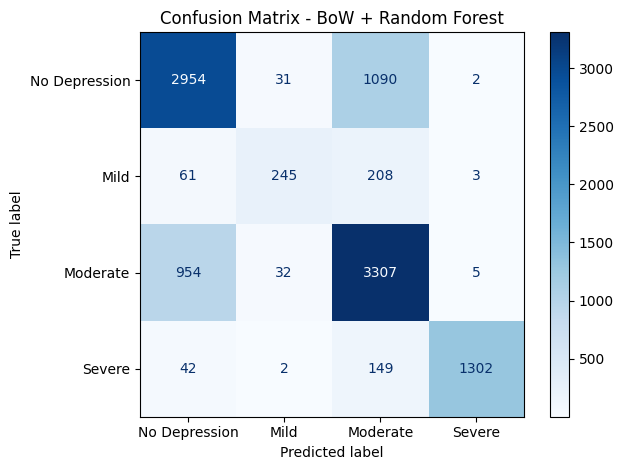


🔍 Training Random Forest with TF-IDF...
 TF-IDF Accuracy: 0.7657648984307307
               precision    recall  f1-score   support

No Depression       0.75      0.74      0.75      4077
         Mild       0.87      0.44      0.59       517
     Moderate       0.71      0.78      0.74      4298
       Severe       0.99      0.91      0.95      1495

     accuracy                           0.77     10387
    macro avg       0.83      0.72      0.76     10387
 weighted avg       0.77      0.77      0.77     10387



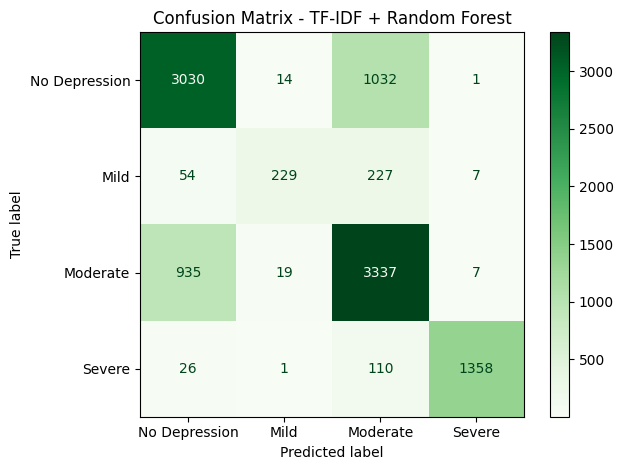

In [25]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Combine and shuffle the dataset

# Split into train and test
train_df, test_df =df_tr,df_tes
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

# Extract texts and labels
X_train = train_df['cleaned_text'].values
y_train = train_df['label'].values
X_test = test_df['cleaned_text'].values
y_test = test_df['label'].values

label_names = ['No Depression', 'Mild', 'Moderate', 'Severe']
labels = sorted(train_df['label'].unique())


# ---- TF-IDF ----
print("\n🔍 Training Random Forest with TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)

print(" TF-IDF Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf, target_names=label_names))

# Confusion matrix for TF-IDF
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=label_names)
disp_tfidf.plot(cmap="Greens", values_format='d')
plt.title("Confusion Matrix - TF-IDF + Random Forest")
plt.tight_layout()
plt.show()


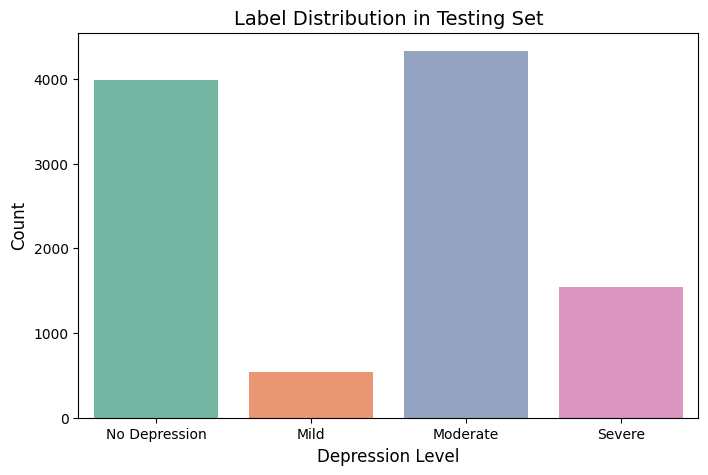

label
No Depression    39.41%
Mild              4.95%
Moderate         41.33%
Severe           14.31%
Name: proportion, dtype: object


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Defining custom label names
label_names = {
    0: "No Depression",
    1: "Mild",
    2: "Moderate",
    3: "Severe"
}
plt.figure(figsize=(8, 5))
sns.countplot(data= test_df, x="label", palette="Set2")
plt.title("Label Distribution in Testing Set", fontsize=14)
plt.xlabel("Depression Level", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=[label_names[i] for i in range(4)])
plt.show()

# Printing a percentage distribution
print(train_df["label"].value_counts(normalize=True).sort_index().rename(index=label_names).apply(lambda x: f"{x:.2%}"))


In [10]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA available: True
GPU name: Tesla P100-PCIE-16GB


# DISTILBERT MODEL

2025-05-28 15:22:54.296004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748445774.464787      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748445774.515639      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training the DistilBERT model...

Epoch 1/3


100%|██████████| 7363/7363 [07:57<00:00, 15.42it/s]


Train Loss: 0.5010 | Train Acc: 0.7906


100%|██████████| 2599/2599 [00:26<00:00, 96.51it/s]


Test Loss: 0.4678 | Test Acc: 0.8114
✅ New best model saved with accuracy: 0.8114

Epoch 2/3


100%|██████████| 7363/7363 [07:56<00:00, 15.45it/s]


Train Loss: 0.3638 | Train Acc: 0.8645


100%|██████████| 2599/2599 [00:26<00:00, 96.94it/s]


Test Loss: 0.4998 | Test Acc: 0.8213
✅ New best model saved with accuracy: 0.8213

Epoch 3/3


100%|██████████| 7363/7363 [07:56<00:00, 15.46it/s]


Train Loss: 0.2731 | Train Acc: 0.9157


100%|██████████| 2599/2599 [00:26<00:00, 96.77it/s]


Test Loss: 0.7088 | Test Acc: 0.8187

Performing final evaluation...


100%|██████████| 2599/2599 [00:26<00:00, 96.57it/s]


Final Test Accuracy: 0.8213
               precision    recall  f1-score   support

Not Depressed       0.79      0.82      0.81      3989
         Mild       0.68      0.66      0.67       537
     Moderate       0.81      0.79      0.80      4328
       Severe       0.99      0.96      0.98      1539

     accuracy                           0.82     10393
    macro avg       0.82      0.81      0.81     10393
 weighted avg       0.82      0.82      0.82     10393



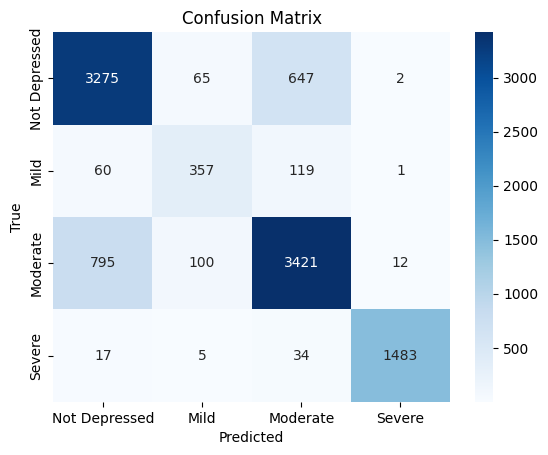

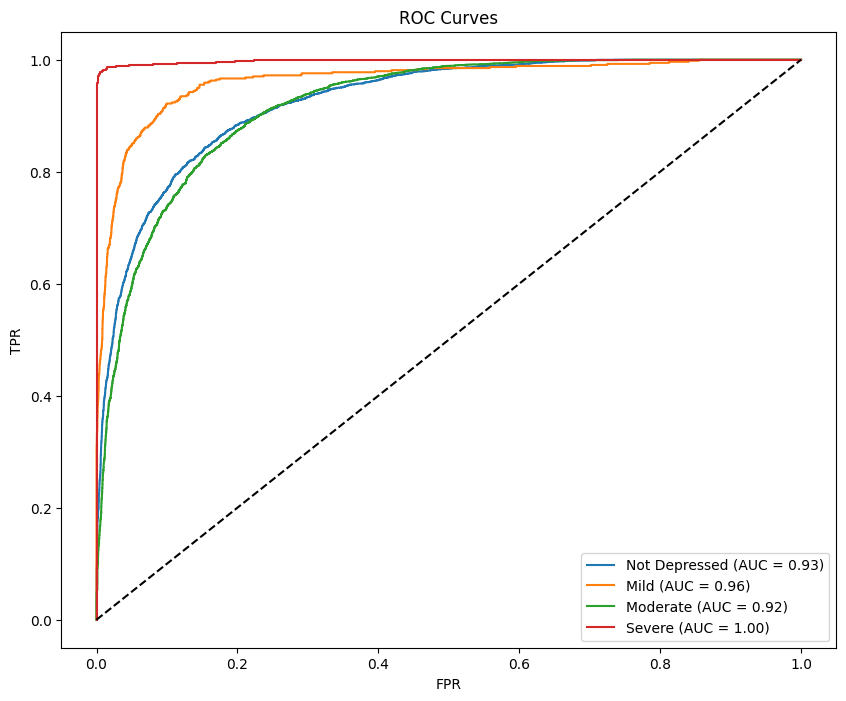

Saving the model...
Model and metadata saved successfully!


In [4]:
# DistilBERT-based Multiclass Text Classification Pipeline

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm

LABEL_MAPPING = {
    0: "Not Depressed",
    1: "Mild",
    2: "Moderate",
    3: "Severe"
}

MODEL_RESULTS = {}  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, correct = 0, 0
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct / len(loader.dataset), total_loss / len(loader)

def eval_model(model, loader):
    model.eval()
    correct, total_loss = 0, 0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            correct += (preds == labels).sum().item()
            total_loss += loss.item()
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())

    return correct / len(loader.dataset), total_loss / len(loader), all_labels, all_preds, all_probs

def evaluate_and_visualize(y_true, y_pred, y_probs):
    print(classification_report(y_true, y_pred, target_names=list(LABEL_MAPPING.values())))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_MAPPING.values(), yticklabels=LABEL_MAPPING.values())
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()

    y_onehot = np.zeros((len(y_true), 4))
    for i, label in enumerate(y_true):
        y_onehot[i, label] = 1

    plt.figure(figsize=(10, 8))
    aucs = []
    for i in range(4):
        fpr, tpr, _ = roc_curve(y_onehot[:, i], [p[i] for p in y_probs])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, label=f"{LABEL_MAPPING[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves')
    plt.legend(); plt.show()

    return dict(zip(LABEL_MAPPING.values(), aucs)), np.mean(aucs)

def main():
    global MODEL_RESULTS
    train_df, test_df = df_tr, df_tes

    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    train_data = DepressionDataset(train_df['cleaned_text'].tolist(), train_df['label'].tolist(), tokenizer)
    test_data = DepressionDataset(test_df['cleaned_text'].tolist(), test_df['label'].tolist(), tokenizer)

    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=4)

    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 5)

    print("Training the DistilBERT model...")
    best_accuracy = 0
    epochs = 3

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler)
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

        test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader)
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), "best_distilbert_model.pth")
            print(f"\u2705 New best model saved with accuracy: {best_accuracy:.4f}")

    print("\nPerforming final evaluation...")
    model.load_state_dict(torch.load("best_distilbert_model.pth"))
    test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader)
    print(f'Final Test Accuracy: {test_acc:.4f}')

    roc_auc_dict, macro_roc_auc = evaluate_and_visualize(labels, predictions, probs)

    # Store results in global MODEL_RESULTS
    MODEL_RESULTS["DistilBERT"] = {
        "y_true": labels,
        "y_pred": predictions,
        "y_probs": probs,
        "roc_auc": roc_auc_dict,
        "macro_roc_auc": macro_roc_auc,
        "test_accuracy": test_acc
    }

    print("Saving the model...")
    model.save_pretrained("distilbert_depression_model")
    tokenizer.save_pretrained("distilbert_depression_model")

    model_info = {
        "model_type": "DistilBERT",
        "base_model": "distilbert-base-uncased",
        "num_classes": 4,
        "class_names": list(LABEL_MAPPING.values()),
        "model_version": "1.0",
        "test_accuracy": float(test_acc),
        "macro_roc_auc": float(macro_roc_auc)
    }

    with open("distilbert_depression_model/model_info.json", 'w') as f:
        json.dump(model_info, f, indent=4)

    print("Model and metadata saved successfully!")

if __name__ == "__main__":
    main()

# Bert_base MODEL

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training the BERT-base model...

Epoch 1/3


100%|██████████| 3682/3682 [12:34<00:00,  4.88it/s]


Train Loss: 0.4828 | Train Acc: 0.7949


100%|██████████| 2599/2599 [00:48<00:00, 53.73it/s]


Test Loss: 0.4189 | Test Acc: 0.8216
✅ New best model saved with accuracy: 0.8216

Epoch 2/3


100%|██████████| 3682/3682 [12:34<00:00,  4.88it/s]


Train Loss: 0.3213 | Train Acc: 0.8740


100%|██████████| 2599/2599 [00:48<00:00, 53.52it/s]


Test Loss: 0.4828 | Test Acc: 0.8354
✅ New best model saved with accuracy: 0.8354

Epoch 3/3


100%|██████████| 3682/3682 [12:34<00:00,  4.88it/s]


Train Loss: 0.2025 | Train Acc: 0.9303


100%|██████████| 2599/2599 [00:48<00:00, 53.49it/s]


Test Loss: 0.5912 | Test Acc: 0.8291

Performing final evaluation...


100%|██████████| 2599/2599 [00:48<00:00, 53.63it/s]


Final Test Accuracy: 0.8354
               precision    recall  f1-score   support

Not Depressed       0.83      0.80      0.82      3989
         Mild       0.71      0.63      0.67       537
     Moderate       0.80      0.84      0.82      4328
       Severe       0.99      0.97      0.98      1539

     accuracy                           0.84     10393
    macro avg       0.83      0.81      0.82     10393
 weighted avg       0.84      0.84      0.84     10393



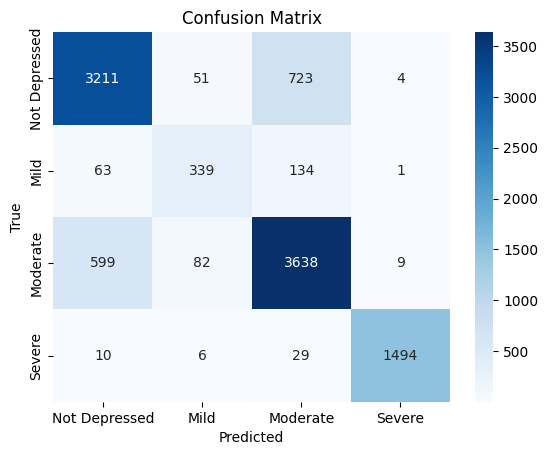

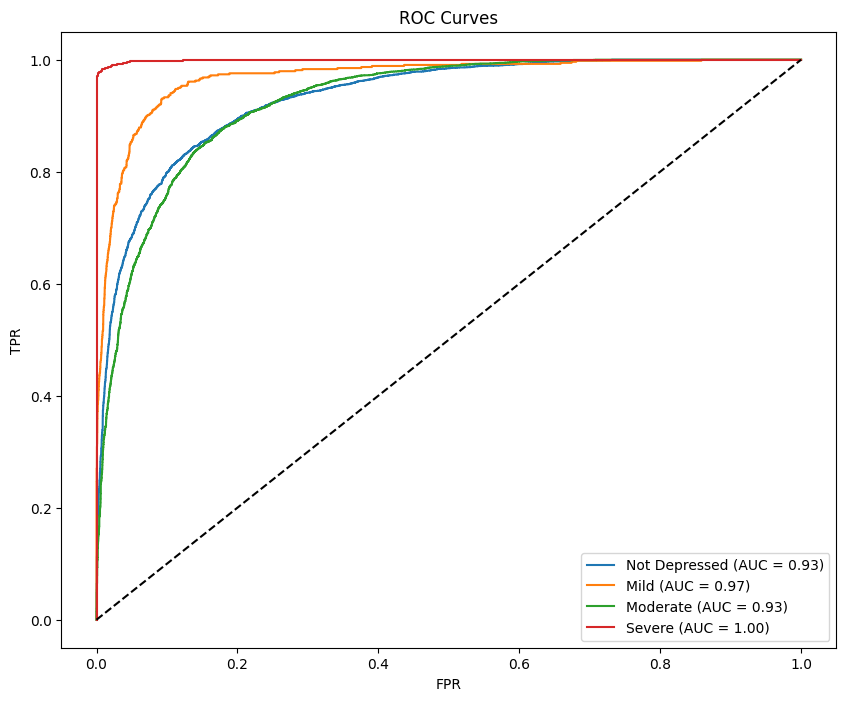

Saving the model...
Model and metadata saved successfully!


In [5]:
# BERT-base Multiclass Text Classification Pipeline

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm

LABEL_MAPPING = {
    0: "Not Depressed",
    1: "Mild",
    2: "Moderate",
    3: "Severe"
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, correct = 0, 0
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct / len(loader.dataset), total_loss / len(loader)

def eval_model(model, loader):
    model.eval()
    correct, total_loss = 0, 0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            correct += (preds == labels).sum().item()
            total_loss += loss.item()
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())

    return correct / len(loader.dataset), total_loss / len(loader), all_labels, all_preds, all_probs

def evaluate_and_visualize(y_true, y_pred, y_probs):
    print(classification_report(y_true, y_pred, target_names=list(LABEL_MAPPING.values())))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_MAPPING.values(), yticklabels=LABEL_MAPPING.values())
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()

    y_onehot = np.zeros((len(y_true), 4))
    for i, label in enumerate(y_true):
        y_onehot[i, label] = 1

    plt.figure(figsize=(10, 8))
    aucs = []
    for i in range(4):
        fpr, tpr, _ = roc_curve(y_onehot[:, i], [p[i] for p in y_probs])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, label=f"{LABEL_MAPPING[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves')
    plt.legend(); plt.show()

    return dict(zip(LABEL_MAPPING.values(), aucs)), np.mean(aucs)

def main():
    train_df, test_df = df_tr, df_tes

    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    train_data = DepressionDataset(train_df['cleaned_text'].tolist(), train_df['label'].tolist(), tokenizer)
    test_data = DepressionDataset(test_df['cleaned_text'].tolist(), test_df['label'].tolist(), tokenizer)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=4)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 5)

    print("Training the BERT-base model...")
    best_accuracy = 0
    epochs = 3

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler)
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

        test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader)
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), "best_bert_model.pth")
            print(f"✅ New best model saved with accuracy: {best_accuracy:.4f}")

    print("\nPerforming final evaluation...")
    model.load_state_dict(torch.load("best_bert_model.pth"))
    test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader)
    print(f'Final Test Accuracy: {test_acc:.4f}')

    roc_auc_dict, macro_roc_auc = evaluate_and_visualize(labels, predictions, probs)
    MODEL_RESULTS["BERT-base"] = {
    "y_true": labels,
    "y_pred": predictions,
    "y_probs": probs,
    "roc_auc": roc_auc_dict,
    "macro_roc_auc": macro_roc_auc,
    "test_accuracy": test_acc
}



    print("Saving the model...")
    model.save_pretrained("bert_depression_model")
    tokenizer.save_pretrained("bert_depression_model")

    model_info = {
        "model_type": "BERT-base",
        "base_model": "bert-base-uncased",
        "num_classes": 4,
        "class_names": list(LABEL_MAPPING.values()),
        "model_version": "1.0",
        "test_accuracy": float(test_acc),
        "macro_roc_auc": float(macro_roc_auc)
    }

    with open("bert_depression_model/model_info.json", 'w') as f:
        json.dump(model_info, f, indent=4)

    print("Model and metadata saved successfully!")

if __name__ == "__main__":
    main()


# Roberta Model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training the RoBERTa-base model...

Epoch 1/3


100%|██████████| 7363/7363 [15:32<00:00,  7.90it/s]


Train Loss: 0.5106 | Train Acc: 0.7925


100%|██████████| 2599/2599 [00:48<00:00, 53.50it/s]


Test Loss: 0.5044 | Test Acc: 0.8016
✅ New best model saved with accuracy: 0.8016

Epoch 2/3


100%|██████████| 7363/7363 [15:32<00:00,  7.89it/s]


Train Loss: 0.4034 | Train Acc: 0.8495


100%|██████████| 2599/2599 [00:48<00:00, 53.49it/s]


Test Loss: 0.5190 | Test Acc: 0.8325
✅ New best model saved with accuracy: 0.8325

Epoch 3/3


100%|██████████| 7363/7363 [15:32<00:00,  7.90it/s]


Train Loss: 0.3513 | Train Acc: 0.8903


100%|██████████| 2599/2599 [00:48<00:00, 53.57it/s]


Test Loss: 0.5894 | Test Acc: 0.8354
✅ New best model saved with accuracy: 0.8354

Performing final evaluation...


100%|██████████| 2599/2599 [00:48<00:00, 53.25it/s]


Final Test Accuracy: 0.8354
               precision    recall  f1-score   support

Not Depressed       0.82      0.82      0.82      3989
         Mild       0.67      0.65      0.66       537
     Moderate       0.82      0.82      0.82      4328
       Severe       0.98      0.97      0.97      1539

     accuracy                           0.84     10393
    macro avg       0.82      0.82      0.82     10393
 weighted avg       0.84      0.84      0.84     10393



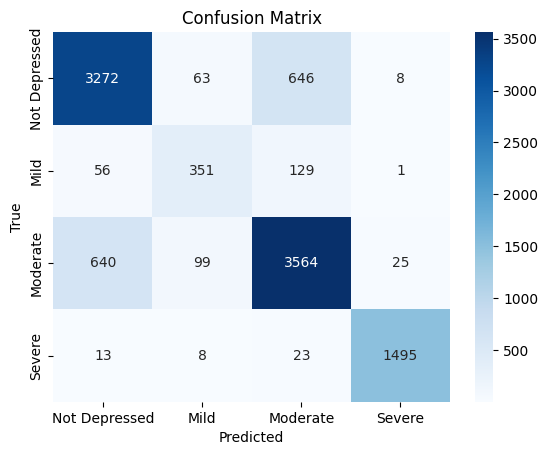

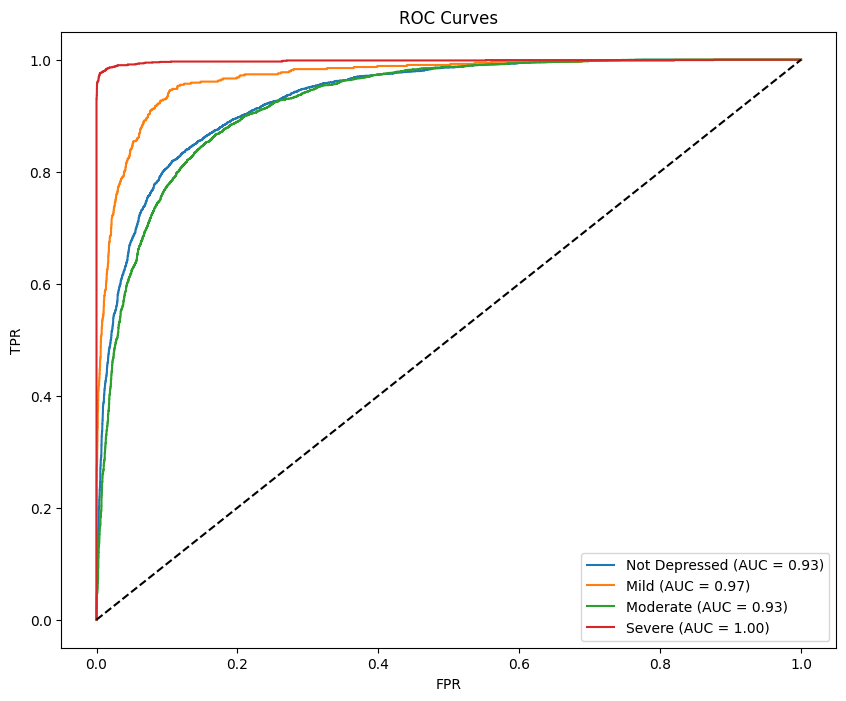

Saving the model...
Model and metadata saved successfully!


In [7]:
# RoBERTa-base Multiclass Text Classification Pipeline

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm

LABEL_MAPPING = {
    0: "Not Depressed",
    1: "Mild",
    2: "Moderate",
    3: "Severe"
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, correct = 0, 0
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct / len(loader.dataset), total_loss / len(loader)

def eval_model(model, loader):
    model.eval()
    correct, total_loss = 0, 0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            correct += (preds == labels).sum().item()
            total_loss += loss.item()
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())

    return correct / len(loader.dataset), total_loss / len(loader), all_labels, all_preds, all_probs

def evaluate_and_visualize(y_true, y_pred, y_probs):
    print(classification_report(y_true, y_pred, target_names=list(LABEL_MAPPING.values())))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_MAPPING.values(), yticklabels=LABEL_MAPPING.values())
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()

    y_onehot = np.zeros((len(y_true), 4))
    for i, label in enumerate(y_true):
        y_onehot[i, label] = 1

    plt.figure(figsize=(10, 8))
    aucs = []
    for i in range(4):
        fpr, tpr, _ = roc_curve(y_onehot[:, i], [p[i] for p in y_probs])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, label=f"{LABEL_MAPPING[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves')
    plt.legend(); plt.show()

    return dict(zip(LABEL_MAPPING.values(), aucs)), np.mean(aucs)

def main():
    train_df, test_df = df_tr, df_tes

    tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
    train_data = DepressionDataset(train_df['cleaned_text'].tolist(), train_df['label'].tolist(), tokenizer)
    test_data = DepressionDataset(test_df['cleaned_text'].tolist(), test_df['label'].tolist(), tokenizer)

    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=4)

    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 5)

    print("Training the RoBERTa-base model...")
    best_accuracy = 0
    epochs = 3

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler)
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

        test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader)
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), "best_roberta_model.pth")
            print(f"✅ New best model saved with accuracy: {best_accuracy:.4f}")

    print("\nPerforming final evaluation...")
    model.load_state_dict(torch.load("best_roberta_model.pth"))
    test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader)
    print(f'Final Test Accuracy: {test_acc:.4f}')

    roc_auc_dict, macro_roc_auc = evaluate_and_visualize(labels, predictions, probs)

    MODEL_RESULTS["RoBERTa-base"] = {
        "y_true": labels,
        "y_pred": predictions,
        "y_probs": probs,
        "roc_auc": roc_auc_dict,
        "macro_roc_auc": macro_roc_auc,
        "test_accuracy": test_acc
    }

    print("Saving the model...")
    model.save_pretrained("roberta_depression_model")
    tokenizer.save_pretrained("roberta_depression_model")

    model_info = {
        "model_type": "RoBERTa-base",
        "base_model": "roberta-base",
        "num_classes": 4,
        "class_names": list(LABEL_MAPPING.values()),
        "model_version": "1.0",
        "test_accuracy": float(test_acc),
        "macro_roc_auc": float(macro_roc_auc)
    }

    with open("roberta_depression_model/model_info.json", 'w') as f:
        json.dump(model_info, f, indent=4)

    print("Model and metadata saved successfully!")

if __name__ == "__main__":
    main()

# Classical model (RF+TF-IDF)

Train size: 58898
Test size: 10393

🔍 Training Random Forest with TF-IDF...
TF-IDF Accuracy: 0.7586837294332724
               precision    recall  f1-score   support

No Depression       0.73      0.73      0.73      3989
         Mild       0.88      0.41      0.56       537
     Moderate       0.71      0.78      0.74      4328
       Severe       1.00      0.90      0.95      1539

     accuracy                           0.76     10393
    macro avg       0.83      0.70      0.74     10393
 weighted avg       0.77      0.76      0.76     10393



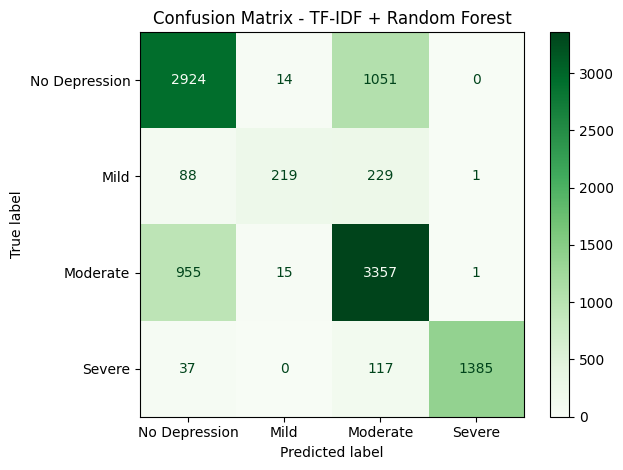

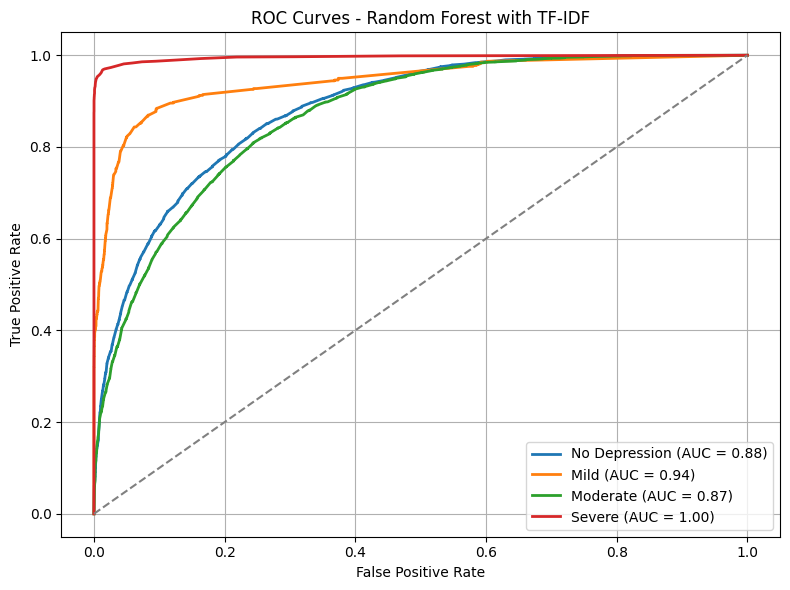

Random Forest model results saved to 'rf_tfidf_model_results.json'


In [23]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import json

# Combine and shuffle the dataset

# Split into train and test
train_df, test_df = df_tr, df_tes
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

# Extract texts and labels
X_train = train_df['cleaned_text'].values
y_train = train_df['label'].values
X_test = test_df['cleaned_text'].values
y_test = test_df['label'].values

label_names = ['No Depression', 'Mild', 'Moderate', 'Severe']
labels = sorted(train_df['label'].unique())

# ---- TF-IDF ----
print("\n🔍 Training Random Forest with TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = rf_tfidf.predict(X_test_tfidf)

print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf, target_names=label_names))

# Confusion matrix for TF-IDF
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, labels=labels)
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=label_names)
disp_tfidf.plot(cmap="Greens", values_format='d')
plt.title("Confusion Matrix - TF-IDF + Random Forest")
plt.tight_layout()
plt.show()

# Calculate predicted probabilities for ROC AUC
y_prob_rf = rf_tfidf.predict_proba(X_test_tfidf)

# Compute ROC AUC per class
y_test_onehot = np.zeros((len(y_test), len(label_names)))
for i, label in enumerate(y_test):
    y_test_onehot[i, label] = 1

roc_auc_dict = {}
for i, label_name in enumerate(label_names):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_dict[label_name] = roc_auc

macro_roc_auc = np.mean(list(roc_auc_dict.values()))
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for i, label_name in enumerate(label_names):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Random Forest with TF-IDF")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

MODEL_RESULTS["RandomForest_TFIDF"] = {
    "y_true": y_test.tolist(),
    "y_pred": y_pred_tfidf.tolist(),
    "y_probs": y_prob_rf.tolist(),
    "roc_auc": roc_auc_dict,
    "macro_roc_auc": float(macro_roc_auc),
    "test_accuracy": float(accuracy_score(y_test, y_pred_tfidf))
}

# Save MODEL_RESULTS to json file
with open("rf_tfidf_model_results.json", "w") as f:
    json.dump(MODEL_RESULTS["RandomForest_TFIDF"], f, indent=4)

print("Random Forest model results saved to 'rf_tfidf_model_results.json'")


In [28]:
import pandas as pd

# Convert MODEL_RESULTS to a format suitable for CSV
rows = []
for model_name, result in MODEL_RESULTS.items():
    for cls, auc_score in result["roc_auc"].items():
        rows.append({
            "Model": model_name,
            "Class": cls,
            "ROC AUC": auc_score,
            "Macro ROC AUC": result["macro_roc_auc"],
            "Test Accuracy": result["test_accuracy"]
        })

# Create DataFrame and save to CSV
results_df = pd.DataFrame(rows)
csv_path = "model_results_summary.csv"
results_df.to_csv(csv_path, index=False)

results_df

,Model,Class,ROC AUC,Macro ROC AUC,Test Accuracy
0,DistilBERT,Not Depressed,0.925832,0.951543,0.821322
1,DistilBERT,Mild,0.963145,0.951543,0.821322
2,DistilBERT,Moderate,0.919391,0.951543,0.821322
3,DistilBERT,Severe,0.997805,0.951543,0.821322
4,BERT-base,Not Depressed,0.932108,0.956496,0.835370
5,BERT-base,Mild,0.968999,0.956496,0.835370
6,BERT-base,Moderate,0.926256,0.956496,0.835370
7,BERT-base,Severe,0.998619,0.956496,0.835370
8,RoBERTa-base,Not Depressed,0.933463,0.956379,0.835370
9,RoBERTa-base,Mild,0.968842,0.956379,0.835370


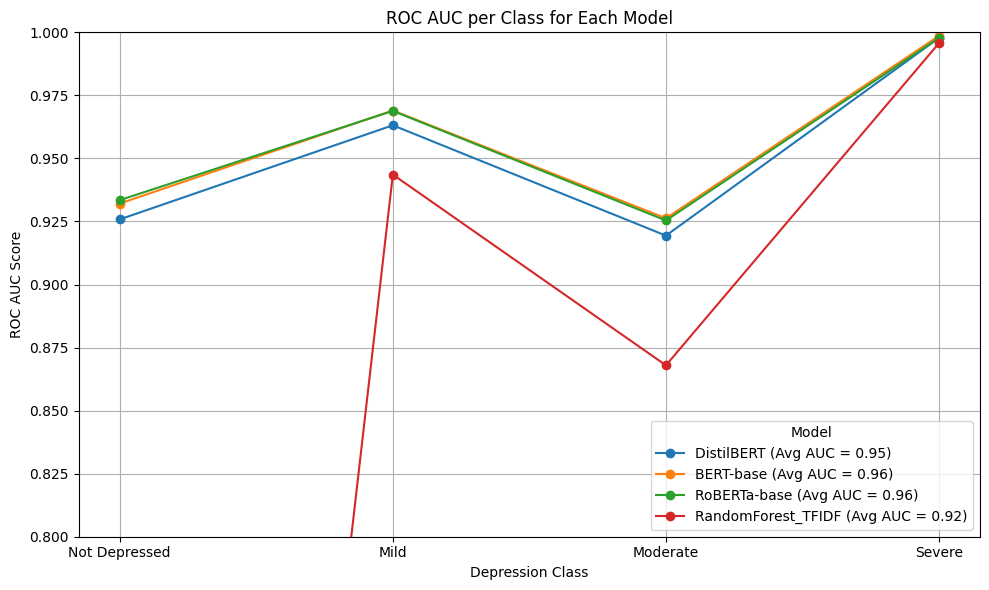

In [36]:
import matplotlib.pyplot as plt

labels = ["Not Depressed", "Mild", "Moderate", "Severe"]
models = results_df["Model"].unique()

plt.figure(figsize=(10, 6))

for model_name in models:
    model_data = results_df[results_df["Model"] == model_name]
    aucs = []
    for label in labels:
        auc = model_data[model_data["Class"] == label]["ROC AUC"].values
        aucs.append(auc[0] if len(auc) > 0 else 0.0)
    
    avg_auc = model_data["Macro ROC AUC"].iloc[0]
    plt.plot(labels, aucs, marker='o', label=f"{model_name} (Avg AUC = {avg_auc:.2f})")

plt.xlabel("Depression Class")
plt.ylabel("ROC AUC Score")
plt.title("ROC AUC per Class for Each Model")
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


2025-05-23 08:06:41.222507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747987601.448912      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747987601.522089      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loaded datasets: Train size = 58855, Test size = 10386


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


100%|██████████| 1840/1840 [11:56<00:00,  2.57it/s]


Train Loss: 0.5921 | Train Acc: 0.7377


100%|██████████| 650/650 [02:49<00:00,  3.83it/s]


Test Loss: 0.4702 | Test Acc: 0.8031
✅ New best model saved with accuracy: 0.8031

Epoch 2/5


100%|██████████| 1840/1840 [11:57<00:00,  2.56it/s]


Train Loss: 0.3868 | Train Acc: 0.8410


100%|██████████| 650/650 [02:49<00:00,  3.83it/s]


Test Loss: 0.4629 | Test Acc: 0.8134
✅ New best model saved with accuracy: 0.8134

Epoch 3/5


100%|██████████| 1840/1840 [11:58<00:00,  2.56it/s]


Train Loss: 0.2447 | Train Acc: 0.9062


100%|██████████| 650/650 [02:50<00:00,  3.82it/s]


Test Loss: 0.5499 | Test Acc: 0.8061

Epoch 4/5


100%|██████████| 1840/1840 [11:58<00:00,  2.56it/s]


Train Loss: 0.1463 | Train Acc: 0.9485


100%|██████████| 650/650 [02:50<00:00,  3.82it/s]


Test Loss: 0.7199 | Test Acc: 0.8036

Epoch 5/5


100%|██████████| 1840/1840 [11:59<00:00,  2.56it/s]


Train Loss: 0.1065 | Train Acc: 0.9632


100%|██████████| 650/650 [02:49<00:00,  3.83it/s]


Test Loss: 0.7199 | Test Acc: 0.8036

Final Evaluation...


100%|██████████| 650/650 [02:49<00:00,  3.83it/s]


Final Test Accuracy: 0.8134

Classification Report:
                     precision    recall  f1-score   support

      No Depression       0.79      0.80      0.79      3987
    Mild Depression       0.68      0.63      0.66       537
Moderate Depression       0.79      0.79      0.79      4323
  Severe Depression       0.98      0.97      0.98      1539

           accuracy                           0.81     10386
          macro avg       0.81      0.80      0.81     10386
       weighted avg       0.81      0.81      0.81     10386



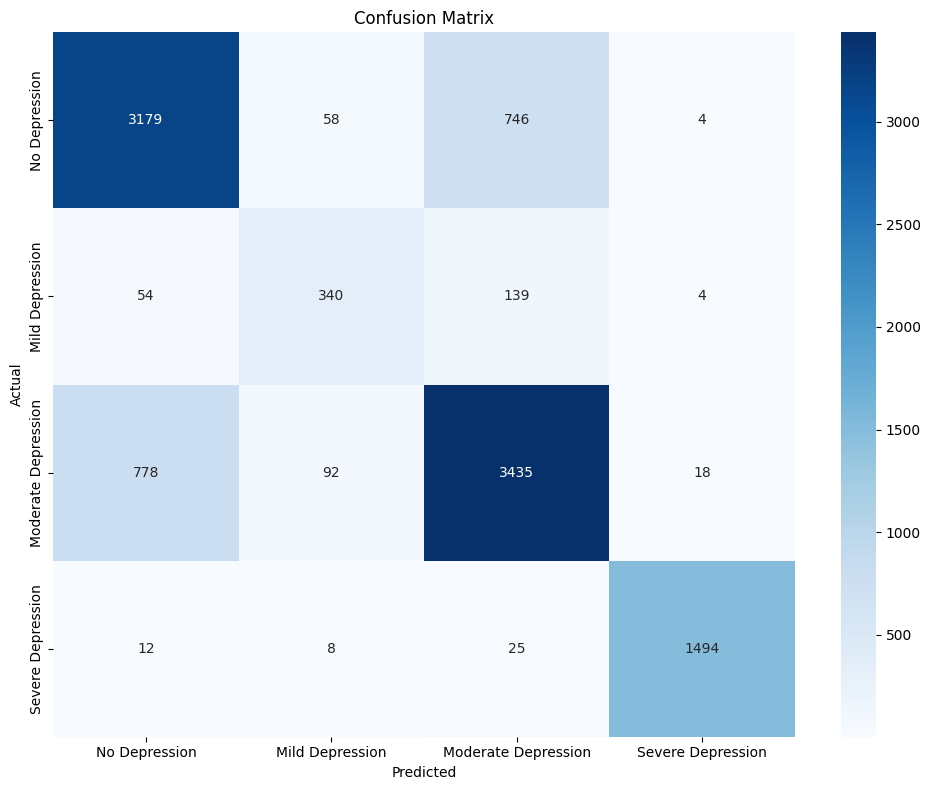

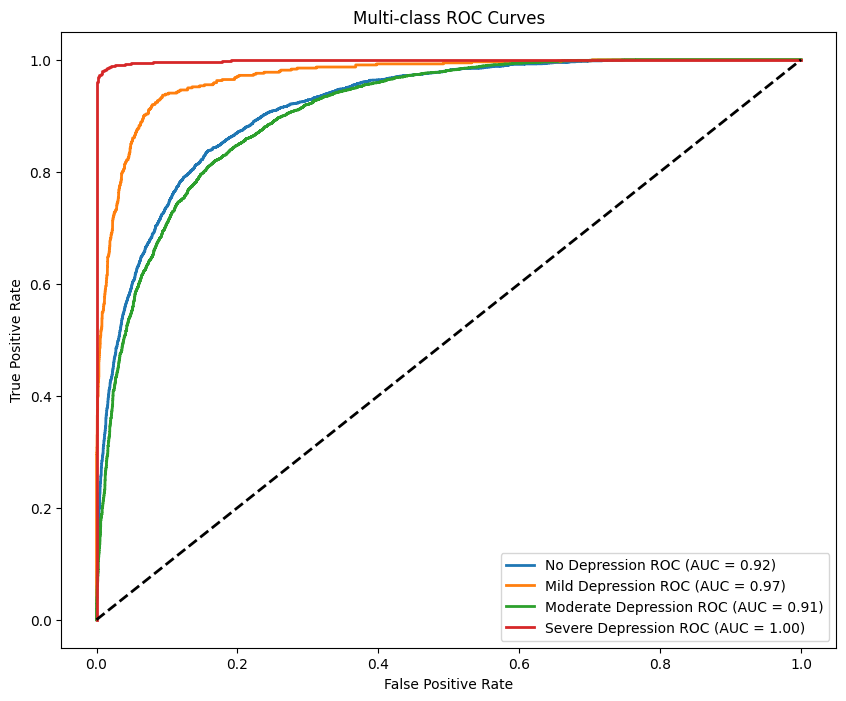


Macro Average ROC AUC Score: 0.9485
Model and metadata saved successfully!


In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import json
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset for BERT
class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Training and evaluation functions
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)

        correct_predictions += torch.sum(preds == labels)
        total_predictions += len(labels)

        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / total_predictions, np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            probs = torch.nn.functional.softmax(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            total_predictions += len(labels)

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())

            losses.append(loss.item())

    return (correct_predictions.double() / total_predictions,
            np.mean(losses),
            all_labels,
            all_preds,
            all_probs)

def evaluate_and_visualize(labels, predictions, probabilities, label_mapping):
    class_names = list(label_mapping.values())
    print("\nClassification Report:")
    print(classification_report(labels, predictions, target_names=class_names))

    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('bert_confusion_matrix.png')
    plt.show()

    y_onehot = np.zeros((len(labels), 4))
    for i, label in enumerate(labels):
        y_onehot[i, label] = 1

    roc_auc_dict = {}
    plt.figure(figsize=(10, 8))
    for i in range(4):
        class_probs = [prob[i] for prob in probabilities]
        fpr, tpr, _ = roc_curve(y_onehot[:, i], class_probs)
        roc_auc = auc(fpr, tpr)
        roc_auc_dict[i] = roc_auc
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} ROC (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig('bert_roc_curves.png')
    plt.show()

    macro_roc_auc = sum(roc_auc_dict.values()) / len(roc_auc_dict)
    print(f"\nMacro Average ROC AUC Score: {macro_roc_auc:.4f}")
    return roc_auc_dict, macro_roc_auc

def main():
    try:
        train_df, test_df = df_tr, df_tes
        print(f"Loaded datasets: Train size = {len(train_df)}, Test size = {len(test_df)}")
    except NameError:
        print("Please define your df_tr and df_tes dataframes before running this code")
        return

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    train_dataset = DepressionDataset(
        texts=train_df['cleaned_text'].tolist(),
        labels=train_df['label'].tolist(),
        tokenizer=tokenizer,
        max_len=128
    )

    test_dataset = DepressionDataset(
        texts=test_df['cleaned_text'].tolist(),
        labels=test_df['label'].tolist(),
        tokenizer=tokenizer,
        max_len=512
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
    model = model.to(device)

    optimizer = AdamW(model.parameters(), 3e-5)
    total_steps = len(train_loader) * 4
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

    best_accuracy = 0
    epochs = 5

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

        test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader, device)
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), "best_bert_depression_model.pth")
            print(f"✅ New best model saved with accuracy: {best_accuracy:.4f}")

    print("\nFinal Evaluation...")
    model.load_state_dict(torch.load("best_bert_depression_model.pth"))
    test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader, device)
    print(f'Final Test Accuracy: {test_acc:.4f}')

    roc_auc_dict, macro_roc_auc = evaluate_and_visualize(labels, predictions, probs, LABEL_MAPPING)

    model.save_pretrained("bert_depression_model")
    tokenizer.save_pretrained("bert_depression_model")

    model_info = {
        "model_type": "BERT",
        "base_model": "bert-base-uncased",
        "num_classes": 4,
        "class_names": list(LABEL_MAPPING.values()),
        "model_version": "1.0",
        "test_accuracy": float(test_acc),
        "macro_roc_auc": float(macro_roc_auc)
    }

    with open("bert_depression_model/model_info.json", 'w') as f:
        json.dump(model_info, f, indent=4)

    print("Model and metadata saved successfully!")

if __name__ == "__main__":
    main()

# BERT base

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Label mapping (update according to your labels)
LABEL_MAPPING = {0: "Not Depressed", 1: "Mild", 2: "Moderate", 3: "Severe"}

# Custom Dataset
class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Training
def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, correct = 0, 0
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct / len(loader.dataset), total_loss / len(loader)

# Evaluation
def eval_model(model, loader):
    model.eval()
    correct, total_loss = 0, 0
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            correct += (preds == labels).sum().item()
            total_loss += loss.item()
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())

    return correct / len(loader.dataset), total_loss / len(loader), all_labels, all_preds, all_probs

# Visualizations
def evaluate_and_visualize(y_true, y_pred, y_probs):
    print(classification_report(y_true, y_pred, target_names=list(LABEL_MAPPING.values())))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=LABEL_MAPPING.values(), yticklabels=LABEL_MAPPING.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    y_onehot = np.zeros((len(y_true), 4))
    for i, label in enumerate(y_true):
        y_onehot[i, label] = 1

    plt.figure(figsize=(10, 8))
    aucs = []
    for i in range(4):
        fpr, tpr, _ = roc_curve(y_onehot[:, i], [p[i] for p in y_probs])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, label=f"{LABEL_MAPPING[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

    macro_roc_auc = np.mean(aucs)
    return aucs, macro_roc_auc

# Main
def main():
    # Replace these with your actual preprocessed DataFrames
    global df_tr, df_tes

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_data = DepressionDataset(df_tr['cleaned_text'].tolist(), df_tr['label'].tolist(), tokenizer)
    test_data = DepressionDataset(df_tes['cleaned_text'].tolist(), df_tes['label'].tolist(), tokenizer)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=4)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * 5)

    print("Training the model...")
    best_accuracy = 0
    epochs = 4

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler)
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

        test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader)
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), "best_bertbase_depression_model.pth")
            print(f"✅ New best model saved with accuracy: {best_accuracy:.4f}")

    # Final evaluation
    print("\nPerforming final evaluation...")
    model.load_state_dict(torch.load("best_bertbase_depression_model.pth"))
    test_acc, test_loss, labels, predictions, probs = eval_model(model, test_loader)
    print(f'Final Test Accuracy: {test_acc:.4f}')

    _, macro_roc_auc = evaluate_and_visualize(labels, predictions, probs)

    print("Saving the model...")
    model.save_pretrained("bertbase_depression_model")
    tokenizer.save_pretrained("bertbase_depression_model")

    model_info = {
        "model_type": "BERT",
        "base_model": "bert-base-uncased",
        "num_classes": 4,
        "class_names": list(LABEL_MAPPING.values()),
        "model_version": "1.0",
        "test_accuracy": float(test_acc),
        "macro_roc_auc": float(macro_roc_auc)
    }

    with open("bertbase_depression_model/model_info.json", 'w') as f:
        json.dump(model_info, f, indent=4)

    print("Model and metadata saved successfully!")

if __name__ == "__main__":
    main()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training the model...

Epoch 1/4


100%|██████████| 3679/3679 [12:34<00:00,  4.88it/s]


Train Loss: 0.5269 | Train Acc: 0.7697


100%|██████████| 2597/2597 [00:50<00:00, 51.06it/s]


Test Loss: 0.4604 | Test Acc: 0.8091
✅ New best model saved with accuracy: 0.8091

Epoch 2/4


100%|██████████| 3679/3679 [12:35<00:00,  4.87it/s]


Train Loss: 0.3755 | Train Acc: 0.8478


100%|██████████| 2597/2597 [00:50<00:00, 51.15it/s]


Test Loss: 0.4997 | Test Acc: 0.8094
✅ New best model saved with accuracy: 0.8094

Epoch 3/4


 88%|████████▊ | 3222/3679 [11:01<01:33,  4.87it/s]